In [7]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import datacleaner
import datetime
imp.reload(datacleaner)

from datacleaner import *

In [16]:
np.random.seed(1)
tf.keras.backend.clear_session()

bd = pd.read_csv(r"USAccDeaths.csv")
bd.pop("Unnamed: 0")
bd

,time,value
0,1973.000000,9007
1,1973.083333,8106
2,1973.166667,8928
3,1973.250000,9137
4,1973.333333,10017
...,...,...
67,1978.583333,9827
68,1978.666667,9110
69,1978.750000,9070
70,1978.833333,8633


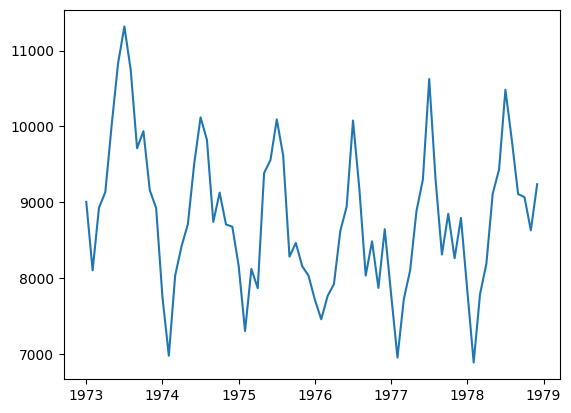

time
1973-01-01   -0.044068
1973-01-31   -0.451299
1973-03-02   -0.079774
1973-04-02    0.014689
1973-05-02    0.412429
                ...   
1978-08-01    0.326554
1978-09-01    0.002486
1978-10-01   -0.015593
1978-11-01   -0.213107
1978-12-01    0.061243
Name: value, Length: 72, dtype: float64

In [17]:
plt.plot(bd["time"],bd["value"])
plt.show()
from datetime import datetime, timedelta
def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    remainder = decimal_year - year
    base_date = datetime(year, 1, 1)
    days_in_year = (datetime(year + 1, 1, 1) - base_date).days
    days_to_add = int(days_in_year * remainder)
    return base_date + timedelta(days=days_to_add)

decimal_years = bd["time"]
dates = [decimal_year_to_date(decimal_year) for decimal_year in decimal_years]

formatted_dates = [date.strftime("%Y-%m-%d") for date in dates]
#formatted_dates = [date.strftime("%Y-%m-%d %H:%M:%S") for date in dates]

bd["time"]=formatted_dates

bd.index = bd['time']
bd.pop("time")
bd["value"]=MinMaxScaler(feature_range=(-1,1)).fit_transform(bd)
bd_normalizado = bd["value"]
bd_normalizado


In [18]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [19]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(bd_normalizado, WINDOW_SIZE)
X1.shape, y1.shape

((67, 5, 1), (67,))

In [20]:
X_train1, y_train1 = X1[:55], y1[:55]
X_val1, y_val1 = X1[55:60], y1[55:60]
X_test1, y_test1 = X1[60:], y1[60:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((55, 5, 1), (55,), (5, 5, 1), (5,), (7, 5, 1), (7,))

In [21]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [22]:
cp1 = ModelCheckpoint('modelNossoLSTM/modelo.h5', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [23]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, callbacks=[cp1])

Epoch 1/1000
2/2 [==============================] - 8s 2s/step - loss: 0.2429 - root_mean_squared_error: 0.4929 - val_loss: 0.4548 - val_root_mean_squared_error: 0.6744
Epoch 2/1000
2/2 [==============================] - 0s 245ms/step - loss: 0.2413 - root_mean_squared_error: 0.4912 - val_loss: 0.4497 - val_root_mean_squared_error: 0.6706
Epoch 3/1000
2/2 [==============================] - 0s 203ms/step - loss: 0.2395 - root_mean_squared_error: 0.4894 - val_loss: 0.4448 - val_root_mean_squared_error: 0.6670
Epoch 4/1000
2/2 [==============================] - 0s 283ms/step - loss: 0.2383 - root_mean_squared_error: 0.4881 - val_loss: 0.4401 - val_root_mean_squared_error: 0.6634
Epoch 5/1000
2/2 [==============================] - 0s 205ms/step - loss: 0.2368 - root_mean_squared_error: 0.4867 - val_loss: 0.4357 - val_root_mean_squared_error: 0.6601
Epoch 6/1000
2/2 [==============================] - 0s 157ms/step - loss: 0.2352 - root_mean_squared_error: 0.4850 - val_loss: 0.4317 - val_roo

KeyboardInterrupt: 

In [59]:
from tensorflow.keras.models import load_model
model2 = load_model('modelNossoLSTM/modelo.h5')

In [60]:
train_predictions = model2.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

2/2 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,0.156789,0.778079
1,0.496610,1.000000
2,0.629787,0.741017
3,0.395485,0.275028
4,0.153428,0.376723
5,0.128117,0.025537
6,-0.026033,-0.080226
7,-0.176934,-0.612203
8,-0.517510,-0.959774
9,-0.627673,-0.482034


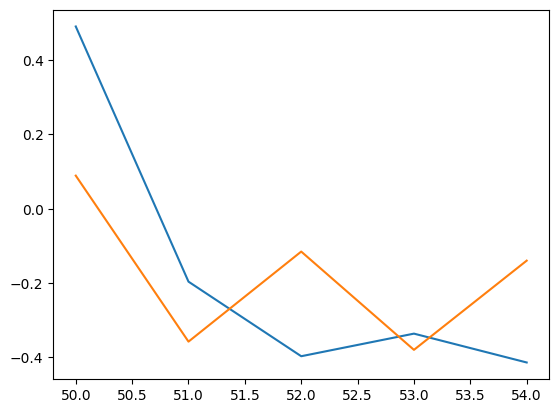

In [61]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [62]:
val_predictions = model2.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

1/1 [==============================] - 0s 16ms/step


,Val Predictions,Actuals
0,-0.378697,-0.573333
1,-0.562598,-1.000000
2,-0.699167,-0.593672
3,-0.534135,-0.412429
4,-0.114219,0.004746


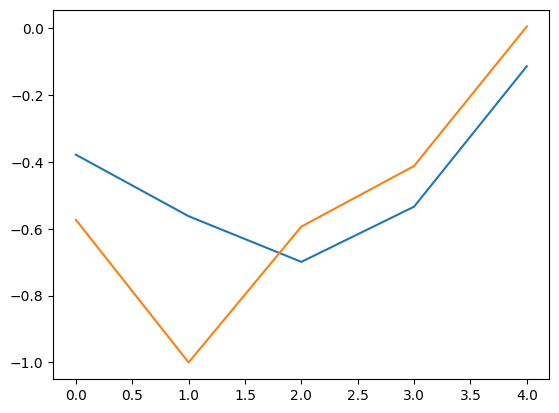

In [63]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [64]:
test_predictions = model2.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

1/1 [==============================] - 0s 15ms/step


,Test Predictions,Actuals
0,0.393086,0.148927
1,0.356742,0.623503
2,0.412022,0.326554
3,0.015900,0.002486
4,-0.168101,-0.015593
5,-0.196198,-0.213107
6,-0.287024,0.061243


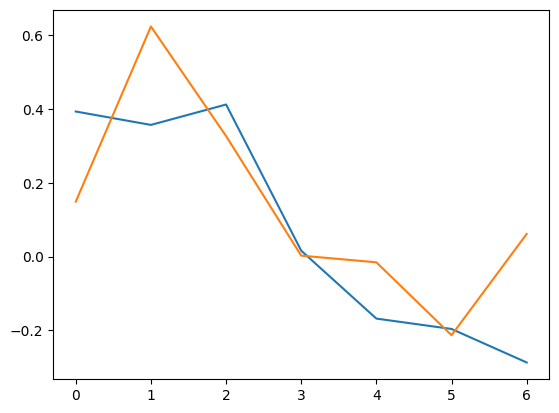

In [65]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])